In [ ]:
# The purpose of this study is to study the predicting power of the U.S LEI Index, through a simple OLS regression on monthly returns in the S&P500, and through a vsual correlation analysis of monthly changes in both vairables.


In [ ]:
# Install all necessary libraries
!pip install pandas_datareader
!pip install yfinance
!pip install fix_yahoo_finance

In [ ]:
# Import Dependencies
from numpy.core.fromnumeric import mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [ ]:
# 1) Determine if there is any correlation between monthly returns in the S&P500 and changes in the U.S LEI Index
#   1.1) Leading Index Indicator: monthly rate of change

# Load data & prepare for numeric analysis
LEI = pd.read_csv("USALOLITONOSTSAM (2).csv")
LEI = LEI.set_index('DATE')
LEI["USALOLITONOSTSAM"] = pd.to_numeric(LEI["USALOLITONOSTSAM"], downcast="float")

# Calculate the  %YoY quarterly logarithmic rate of change
LEI['shifted']=LEI['USALOLITONOSTSAM'].shift(3)
LEI['%MoM']=LEI['USALOLITONOSTSAM']/LEI['shifted']-1
LEI = LEI.dropna()

# Define a x axis with Date for plotting
d = pd.DataFrame(index=LEI.index)
d=d.reset_index()

In [ ]:
LEI

,USALOLITONOSTSAM,shifted,%MoM
DATE,,,
1960-04-01,99.831291,100.692871,-0.008556
1960-05-01,99.581589,100.419693,-0.008346
1960-06-01,99.363548,100.117149,-0.007527
1960-07-01,99.158623,99.831291,-0.006738
1960-08-01,98.964607,99.581589,-0.006196
...,...,...,...
2022-09-01,98.949478,99.484566,-0.005379
2022-10-01,98.832947,99.260300,-0.004305
2022-11-01,98.734795,99.087830,-0.003563


In [ ]:
#    1.2) Determining quarterly returns in the S&P500

# Define the get data function
def get_data(stocks, start, end, interval):
  stockData = pdr.get_data_yahoo(stocks, start, end, interval=interval)
  stockData = stockData['Close']
  return stockData

stocks = '^GSPC'
endDate = dt.datetime.now()
timePeriod = 70*365+60+9
interval = '1d' # note that in the longest data base is in days in Yahoo Finance
startDate = endDate - dt.timedelta(days=timePeriod)
stockData = get_data(stocks, startDate, endDate, interval)

# Create a pandas data frame with quarterly returns
stockData = pd.DataFrame(stockData)
stockData = stockData.resample('M').last()
stockData['shifted']=stockData['Close'].shift(3)
stockData['%MoM']=stockData['Close']/stockData['shifted']-1
stockData = stockData.dropna()

# Adjust our Stock Data to our LEI Data (equal number of observations)
n = 84
stockData = stockData.drop(stockData.index[:n])
stockData = stockData[:-1]

[*********************100%***********************]  1 of 1 completed


In [ ]:
stockData

,Close,shifted,%MoM
Date,,,
1960-04-30,54.369999,55.610001,-0.022298
1960-05-31,55.830002,56.119999,-0.005167
1960-06-30,56.919998,55.340000,0.028551
1960-07-31,55.509998,54.369999,0.020967
1960-08-31,56.959999,55.830002,0.020240
...,...,...,...
2022-09-30,3585.620117,3785.379883,-0.052771
2022-10-31,3871.979980,4130.290039,-0.062540
2022-11-30,4080.110107,3955.000000,0.031633


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                   %MoM   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     217.5
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           2.02e-43
Time:                        20:53:38   Log-Likelihood:                 987.77
No. Observations:                 754   AIC:                            -1972.
Df Residuals:                     752   BIC:                            -1962.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.002      8.480      0.0

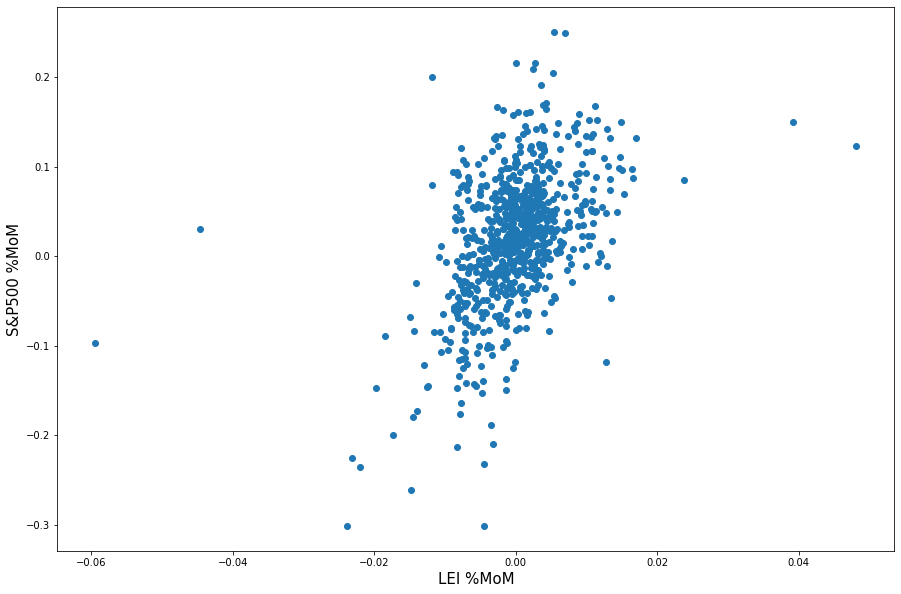

In [ ]:
#     1.3) Run a simple linear regression analysis between the two variables, where S&P500 returns are the dependant variable and LEI is the independent variable

# Load the necessary libraries
import statsmodels.api as sm

# Create new pandas dataframes with variables
y = pd.DataFrame(stockData['%MoM'])
x1 = pd.DataFrame(LEI['%MoM'])

# Reset the Indices of both dataframes
y = y.reset_index().drop(['Date'], axis=1)
x1 = x1.reset_index().drop(['DATE'], axis=1)

# Run de linear regression
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()

# Print results and plot the regression

print(results.summary())
plt.figure(figsize=(15,10))
plt.scatter(x1,y)
plt.xlabel('LEI %MoM', fontsize = 15)
plt.ylabel('S&P500 %MoM', fontsize = 15)
plt.show()

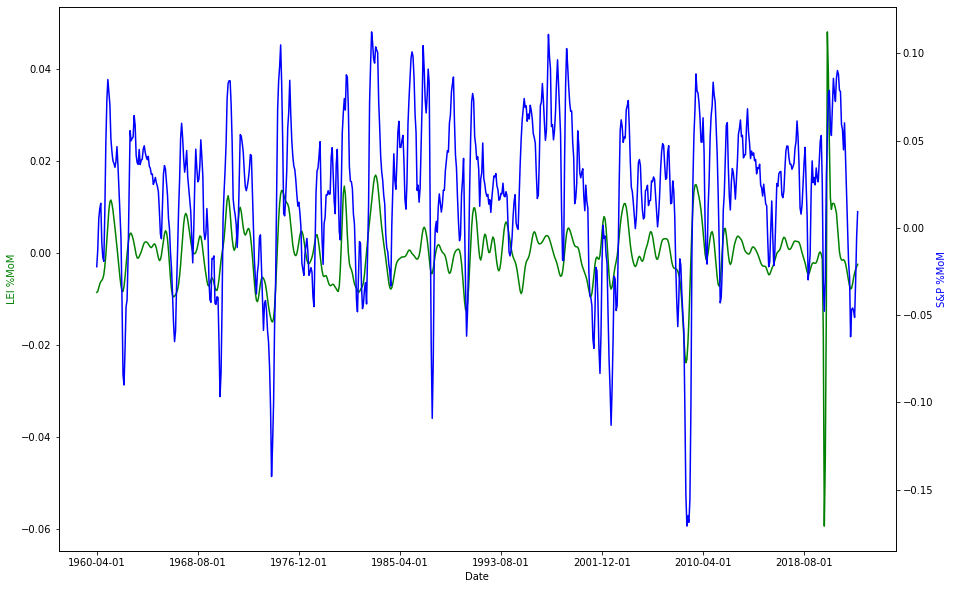

<Figure size 1080x720 with 0 Axes>

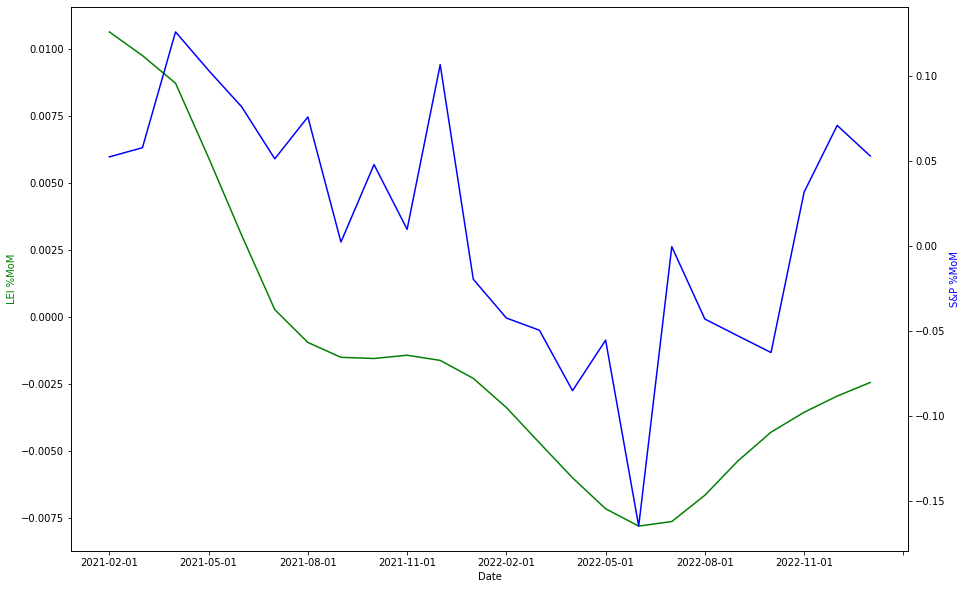

<Figure size 1080x720 with 0 Axes>

In [ ]:
#     1.4) Plotting for data series as time series for visual correlation analysis

# Plotting entire sample
from matplotlib.ticker import MaxNLocator

fig, ax1 = plt.subplots(figsize=(15, 10))

ax2 = ax1.twinx()
plt.figure(figsize=(15,10))
ax1.plot(d['DATE'], LEI['%MoM'], 'g-')
ax2.plot(d['DATE'], stockData['%MoM'].ewm(com=3).mean(), 'b-')

# Set the number of xticks to 10
ax1.xaxis.set_major_locator(MaxNLocator(10))

ax1.set_xlabel('Date')
ax1.set_ylabel('LEI %MoM', color='g')
ax2.set_ylabel('S&P %MoM', color='b')

plt.show()

# Plotting last 2 years
from matplotlib.ticker import MaxNLocator

fig, ax1 = plt.subplots(figsize=(15, 10))

ax2 = ax1.twinx()
plt.figure(figsize=(15,10))
ax1.plot(d['DATE'].iloc[730:755], LEI['%MoM'].iloc[730:755], 'g-')
ax2.plot(d['DATE'].iloc[730:755], stockData['%MoM'].iloc[730:755], 'b-')

# Set the number of xticks to 10
ax1.xaxis.set_major_locator(MaxNLocator(10))

ax1.set_xlabel('Date')
ax1.set_ylabel('LEI %MoM', color='g')
ax2.set_ylabel('S&P %MoM', color='b')

plt.show()

In [ ]:
 #      1.5) Perform a simple Principal Component Analysis